# Setup colab and data paths

To use this notebook on Colab:

Locate the manu bar at the top of this page, go to "Runtime" → "Change runtime type", and select a GPU (e.g. "T4 GPU"). Save your setting.
Run the first two code blocks.
Then, you can import flygym and start writing your own code after the second code block.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

try:
    import flygym
    FLYGYM_INSTALLED = True
except ImportError:
    FLYGYM_INSTALLED = False

if not FLYGYM_INSTALLED:
    if IN_COLAB:
        print(
            "I'm on Colab and FlyGym is not installed. I will try to install it now. "
            "This will take a minute."
        )
        import subprocess
        subprocess.run(
            'pip install "flygym[examples]"',
            shell=True
        )
    else:
        print(
            "FlyGym is not installed, and I'm on your own computer. I can try to "
            "install it here, but I don't want to modify your Python environment "
            "unintentionally. Please install FlyGym yourself following instructions "
            "from https://neuromechfly.org/installation.html"
        )

if IN_COLAB:
    print("In Google Colab. I will now perform some Colab-specific setups.")
    # Set up GPU a few more and rendering parameters. This should take ~1 second.
    from google.colab import files
    import distutils.util
    import os
    import subprocess

    if subprocess.run("nvidia-smi").returncode:
        raise RuntimeError(
            "Cannot communicate with GPU. "
            "Make sure you are using a GPU Colab runtime. "
            "Go to the Runtime menu and select Choose runtime type."
        )

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = "/usr/share/glvnd/egl_vendor.d/10_nvidia.json"
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, "w") as f:
            f.write(
"""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
"""
            )

    # Configure MuJoCo to use the EGL rendering backend (requires GPU)
    print("Setting environment variable to use GPU rendering:")
    %env MUJOCO_GL=egl

    try:
        print("Checking that the installation succeeded:")
        import mujoco

        mujoco.MjModel.from_xml_string("<mujoco/>")
    except Exception as e:
        raise e from RuntimeError(
            "Something went wrong during installation. Check the shell output above "
            "for more information.\n"
            "If using a hosted Colab runtime, make sure you enable GPU acceleration "
            'by going to the Runtime menu and selecting "Choose runtime type".'
        )

    print("Installation successful.")


data_path = "data/inverse_kinematics/leg_joint_angles.pkl"
video_path = "data/video_data/straight_walking_bout.mp4"
if IN_COLAB:
    !wget https://github.com/NeLy-EPFL/neuromechfly-workshop/raw/refs/heads/main/kinematic_replay/data/inverse_kinematics/leg_joint_angles.pkl
    !wget https://github.com/NeLy-EPFL/neuromechfly-workshop/raw/refs/heads/main/kinematic_replay/data/video_data/straight_walking_bout.mp4
    data_path = "leg_joint_angles.pkl"
    video_path = "straight_walking_bout.mp4"
    

# Kinematic replay of untethered locomotion

We now move on to an example where we kinematically replay some experimentally recorded walking behaviors. Specifically, we recorded an untethered fly walking in a narrow corrdior. We used the GUI of SLEAP to manually annotate ~50 frames of behavior recorded at 360 fps and downsampled to 130fps. When then leveraged the simple geometrical constraints of our setup to triangulate the 2d poses to a 3d poses. Used df3d post processing for alignement and interpolation and finally used seqikpy to perform inverse kinematics (e.g calculate the angle at each DoF). All the notebooks used to go from a raw video to joint angles can be found in this repo in the folder: 2d-3d

We will use a PD controller to actuate the DoFs of the simulated fly using these exact angles to see if the fly can walk untethered on flat terrain, as shown in the original NeuroMechFly paper (Lobato-Rios et al., *Nature Methods* 2022).

Here is the above mentioned locomotor behavior we will replay.

In [21]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Like in the previous notebook, we will perform the necessary import define some simulation parameters, format the data and visualize them.

# Data block preprocessing

## Imports

In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import trange

from flygym import Fly, Camera, SingleFlySimulation
from flygym.preprogrammed import all_leg_dofs, all_tarsi_links

## Simulation parameters

In [4]:
timestep = 1e-4
actuated_joints = all_leg_dofs

output_dir = Path("outputs")
output_dir.mkdir(exist_ok=True)

## Format

In [5]:
def format_seqikpy_data(data, corresp_dict={"ThC": "Coxa",
                                             "CTr": "Femur",
                                               "FTi": "Tibia",
                                                 "TiTa": "Tarsus1"}
                                                 ):

    data_gym = {}
    for joint, values in data.items():
        if joint == "meta" or joint == "swing_stance_time":
            data_gym[joint] = values
        else:
            leg = joint[6:8]
            joint_name = joint[9:]
            seg, dof = joint_name.split("_")
            if dof == "pitch":
                newjoint = f"joint_{leg}{corresp_dict[seg]}"
            else:
                newjoint = f"joint_{leg}{corresp_dict[seg]}_{dof}"

            data_gym[newjoint] = values


    return data_gym

seq_ikpy_data_path = Path(data_path)
with open(seq_ikpy_data_path, "rb") as f:
    seq_ikdata = pickle.load(f)

data = format_seqikpy_data(seq_ikdata)

data["meta"].keys()

dict_keys(['timestep', 'source', 'status', 'interpolated', 'smoothed', 'window_size', 'conv_casting'])

In [6]:
run_time = len(data["joint_RFCoxa_yaw"])*data["meta"]["timestep"]

target_num_steps = int(run_time / timestep)
data_block = np.zeros((len(actuated_joints), target_num_steps))
input_t = np.arange(len(data["joint_LFCoxa"])) * data["meta"]["timestep"]
output_t = np.arange(target_num_steps) * timestep
for i, joint in enumerate(actuated_joints):
    data_block[i, :] = np.interp(output_t, input_t, data[joint])

print("Neuromechfly has {} actuated joints and the data contains {} interpolated steps adding up to a toal of {} seconds".format(*data_block.shape, run_time))

Neuromechfly has 42 actuated joints and the data contains 4390 interpolated steps adding up to a toal of 0.439 seconds


In [7]:
# The fly should walk more on the tippy toes
tarsus_offset = np.zeros(len(actuated_joints))
for i, joint in enumerate(actuated_joints):
    if "Tarsus" in joint:
        data_block[i, :] = -1*np.pi/5

## Visualize

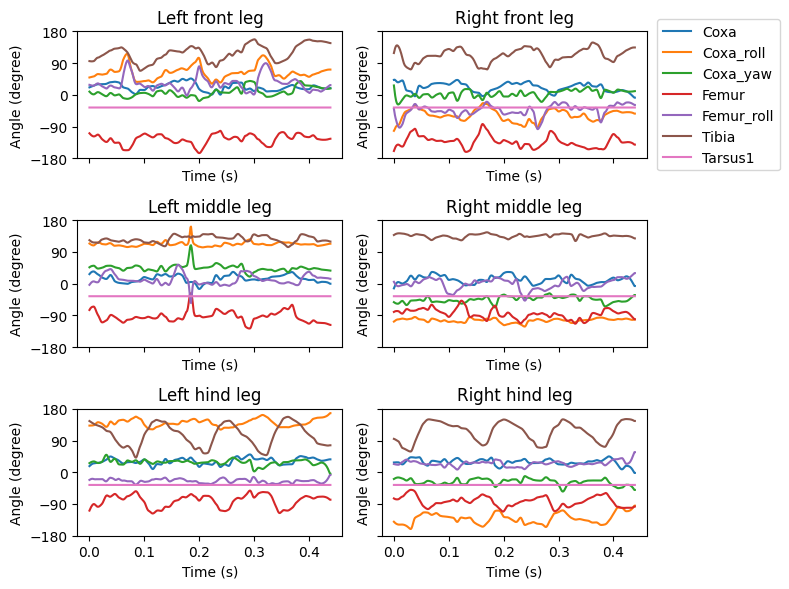

In [8]:
fig, axs = plt.subplots(
    3, 2, figsize=(8, 6), sharex=True, sharey=True, tight_layout=True
)
legs = [
    f"{side} {pos} leg"
    for pos in ["front", "middle", "hind"]
    for side in ["Left", "Right"]
]
for i, leg in enumerate(legs):
    ax = axs.flatten()[i]
    leg_code = f"{leg.split()[0][0]}{leg.split()[1][0]}".upper()
    for j, dof in enumerate(actuated_joints):
        if dof.split("_")[1][:2] != leg_code:
            continue
        ax.plot(output_t, np.rad2deg(data_block[j, :]), label=dof[8:])
    ax.set_ylim(-180, 180)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Angle (degree)")
    ax.set_yticks([-180, -90, 0, 90, 180])
    ax.set_title(leg)
    if leg == "Right front leg":
        ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

fig.savefig(output_dir / "single_step.png")

In every leg 7 degrees of freedom are actuated adding up to 6*7 actuated joints.

# Run kinematic replay

Lets focus on the heart of this notebook: kinematic replay

In [17]:
# Monitor the tarsus passive joints
tarsal_joints = ["_".join(["joint", tarsus_seg]) for tarsus_seg in all_tarsi_links if not "Tarsus1" in tarsus_seg]
monitored_joints = actuated_joints + tarsal_joints

# more info about those simulation parameters at neuromechfly.org
fly = Fly(init_pose="tripod", actuated_joints=actuated_joints, control="position", monitored_joints=monitored_joints, enable_vision=True, render_raw_vision=True)
play_speed = 0.05
# The camera parameters allows to visualize the magnitude and direction of the contact forces applied by the ground on the fly legs
cam = Camera(fly=fly, camera_id="Animat/camera_left", play_speed=play_speed, draw_contacts=True, play_speed_text=True)
sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
)
obs, info = sim.reset()

obs_list = []
raw_vision_list = []
vision_list = []

for i in trange(target_num_steps):
    # here, we simply use the recorded joint angles as the target joint angles
    obs, reward, terminated, truncated, info = sim.step({"joints": data_block[:, i]})

    # reduce RAM usage by removing the vision data and storing it separately if needed
    vision = obs.pop("vision")
    obs_list.append(obs.copy())
    if fly.render_raw_vision and fly._vision_update_mask[-1]:
        raw_vision_list.append(info["raw_vision"])
        vision_list.append(vision)

    sim.render()

100%|██████████| 4390/4390 [00:16<00:00, 258.99it/s]


In [18]:
video_name = "kinematic_replay_{}.mp4".format(cam.camera_id.split("/")[1])
if cam.draw_contacts:
    video_name = video_name.replace(".mp4", "_contacts.mp4")

output_path = output_dir / video_name   
cam.save_video(output_path, stabilization_time=0)


mp4 = open(output_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

The first output of kinematic replay is a video that can be rendered from any different angles. Arrows at the leg tips represent the contact forces with the floor with blue being forces along the z axis, green arrows represent forces along the y axis and red arrows along the x axis.

## Observation space

In [11]:
print(f"Observation list made {len(obs_list)} observations")
print("One observation contains information about:")
for key in obs_list[0].keys():
    try:
        print(key, obs[key].shape)
    except AttributeError:
        print(key)

Observation list made 4390 observations
One observation contains information about:
joints (3, 66)
fly (4, 3)
contact_forces (30, 3)
end_effectors (6, 3)
fly_orientation (3,)
cardinal_vectors (3, 3)


## Floor contact force

While surely contributing to adaptative motor control ground reaction forces are really hard to measure in behaving *Drosophila* melanogaster. Using Neuromechfly it is possible to infer those forces and study their contribution to adaptative motor control.

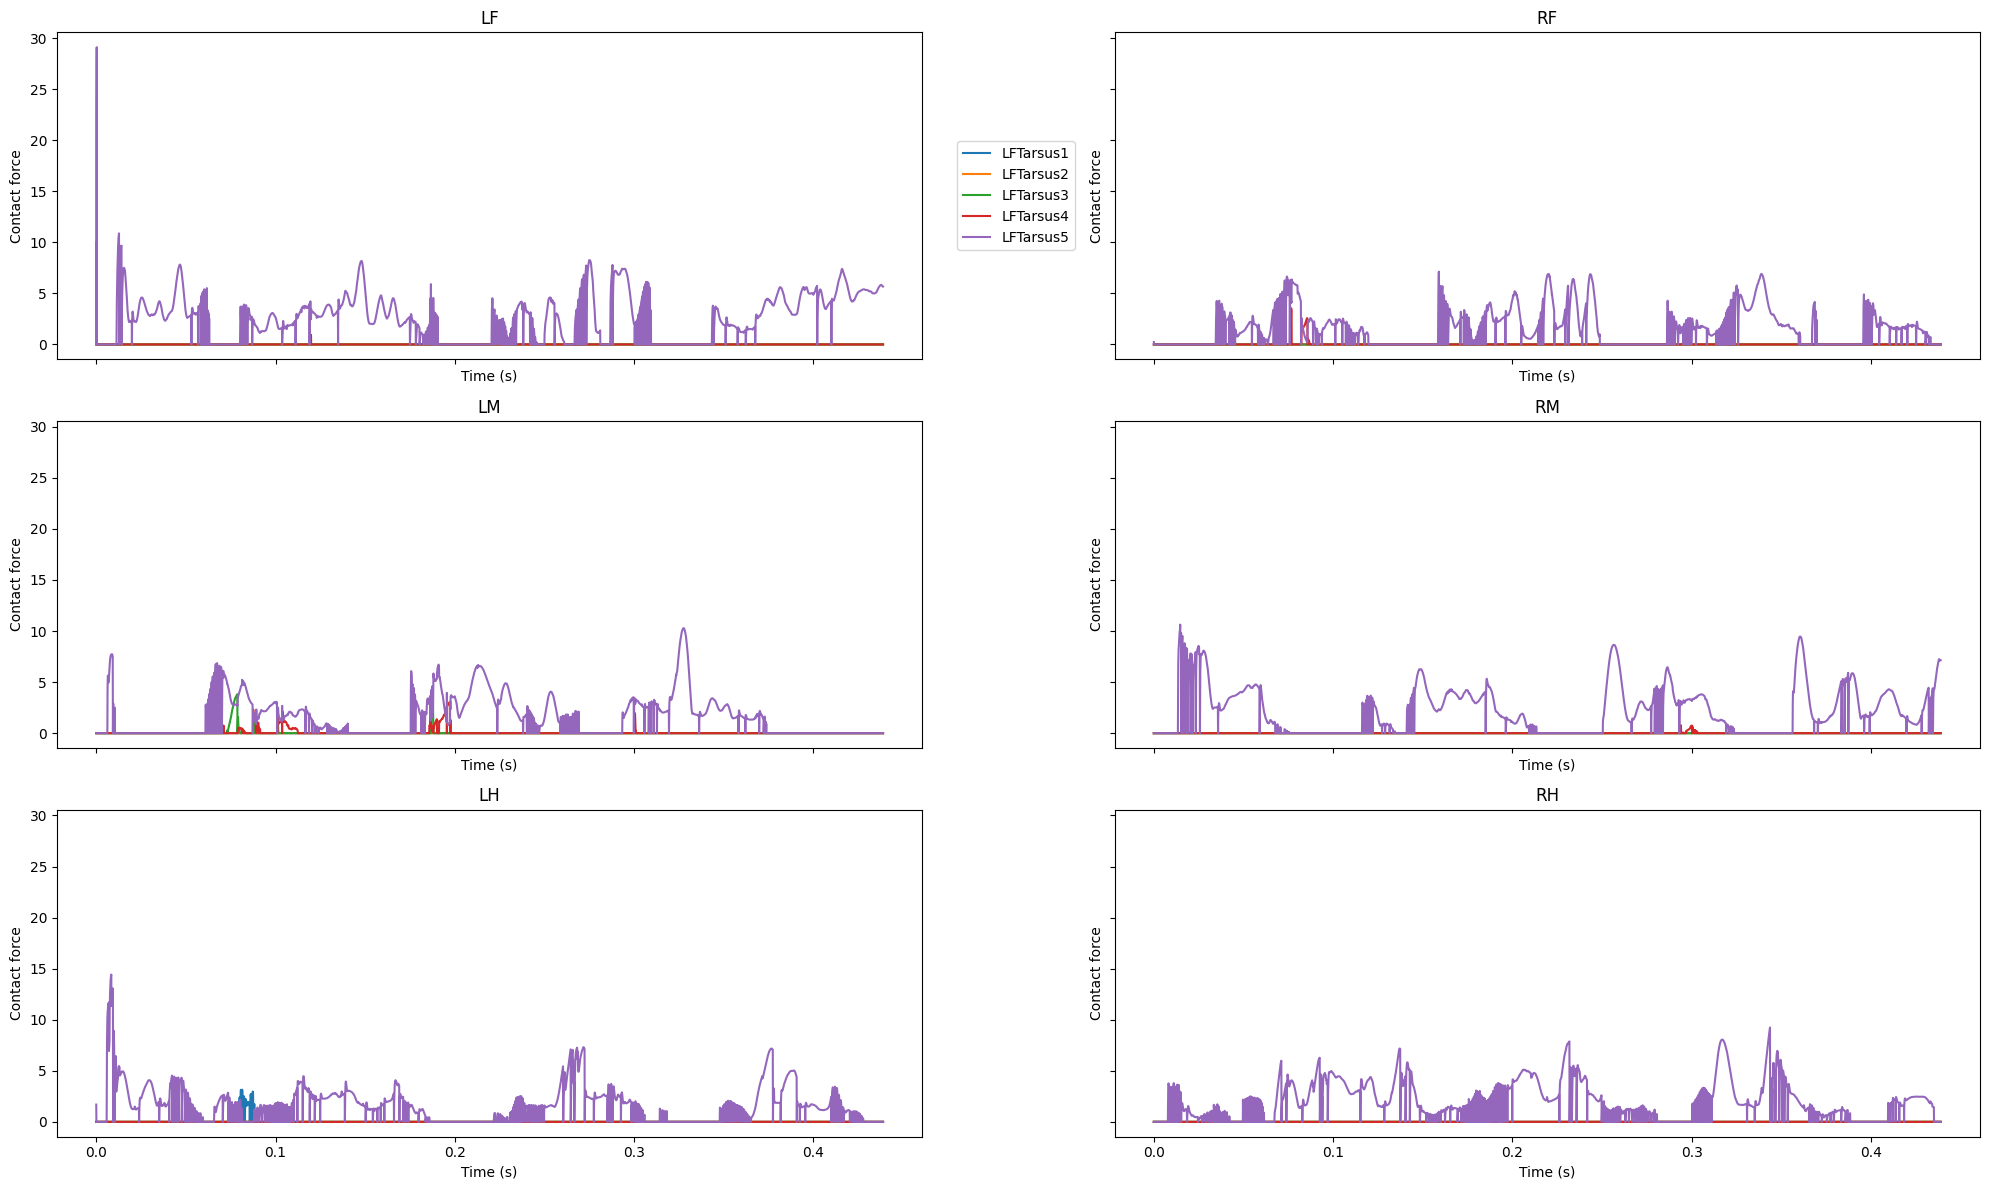

In [28]:
legs = [side+pos for pos in "FMH" for side in "LR"]

leg_tarsal_seg_contact_id = {leg: [i for i, tarsal_seg in enumerate(all_tarsi_links) if leg in tarsal_seg] for leg in legs}
leg_contacts = np.array([[np.linalg.norm(obs["contact_forces"][leg_tarsal_seg_contact_id[leg], :], axis=1) for obs in obs_list] for leg in legs])
leg_contact_tarsalseg = {leg: [tarsal_seg for tarsal_seg in all_tarsi_links if leg in tarsal_seg] for leg in legs}

time = np.arange(len(leg_contacts[0])) * timestep

fig, axs = plt.subplots(
    3, 2, figsize=(20, 12), tight_layout=True, sharex=True, sharey=True
)

for i, leg in enumerate(legs):
    ax = axs.flatten()[i]
    for j, tarsalseg in enumerate(leg_contact_tarsalseg[leg]):
        ax.plot(output_t, leg_contacts[i, :, j], label=leg_contact_tarsalseg[leg][j])
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Contact force")
    if leg == "LF":
        ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

    ax.set_title(leg)

## Joint torques

Torque within joints would be impossible to monitor in a behaving fly. Being able to infer them from kinematic replay allows us to get an abstract sensory signal that could be extracted from the fly's sensory organs. With more modelling efforts one could directly implement sensory organs that would change their firing rate depending on the experienced torque.

### Torque in actively controlled joints

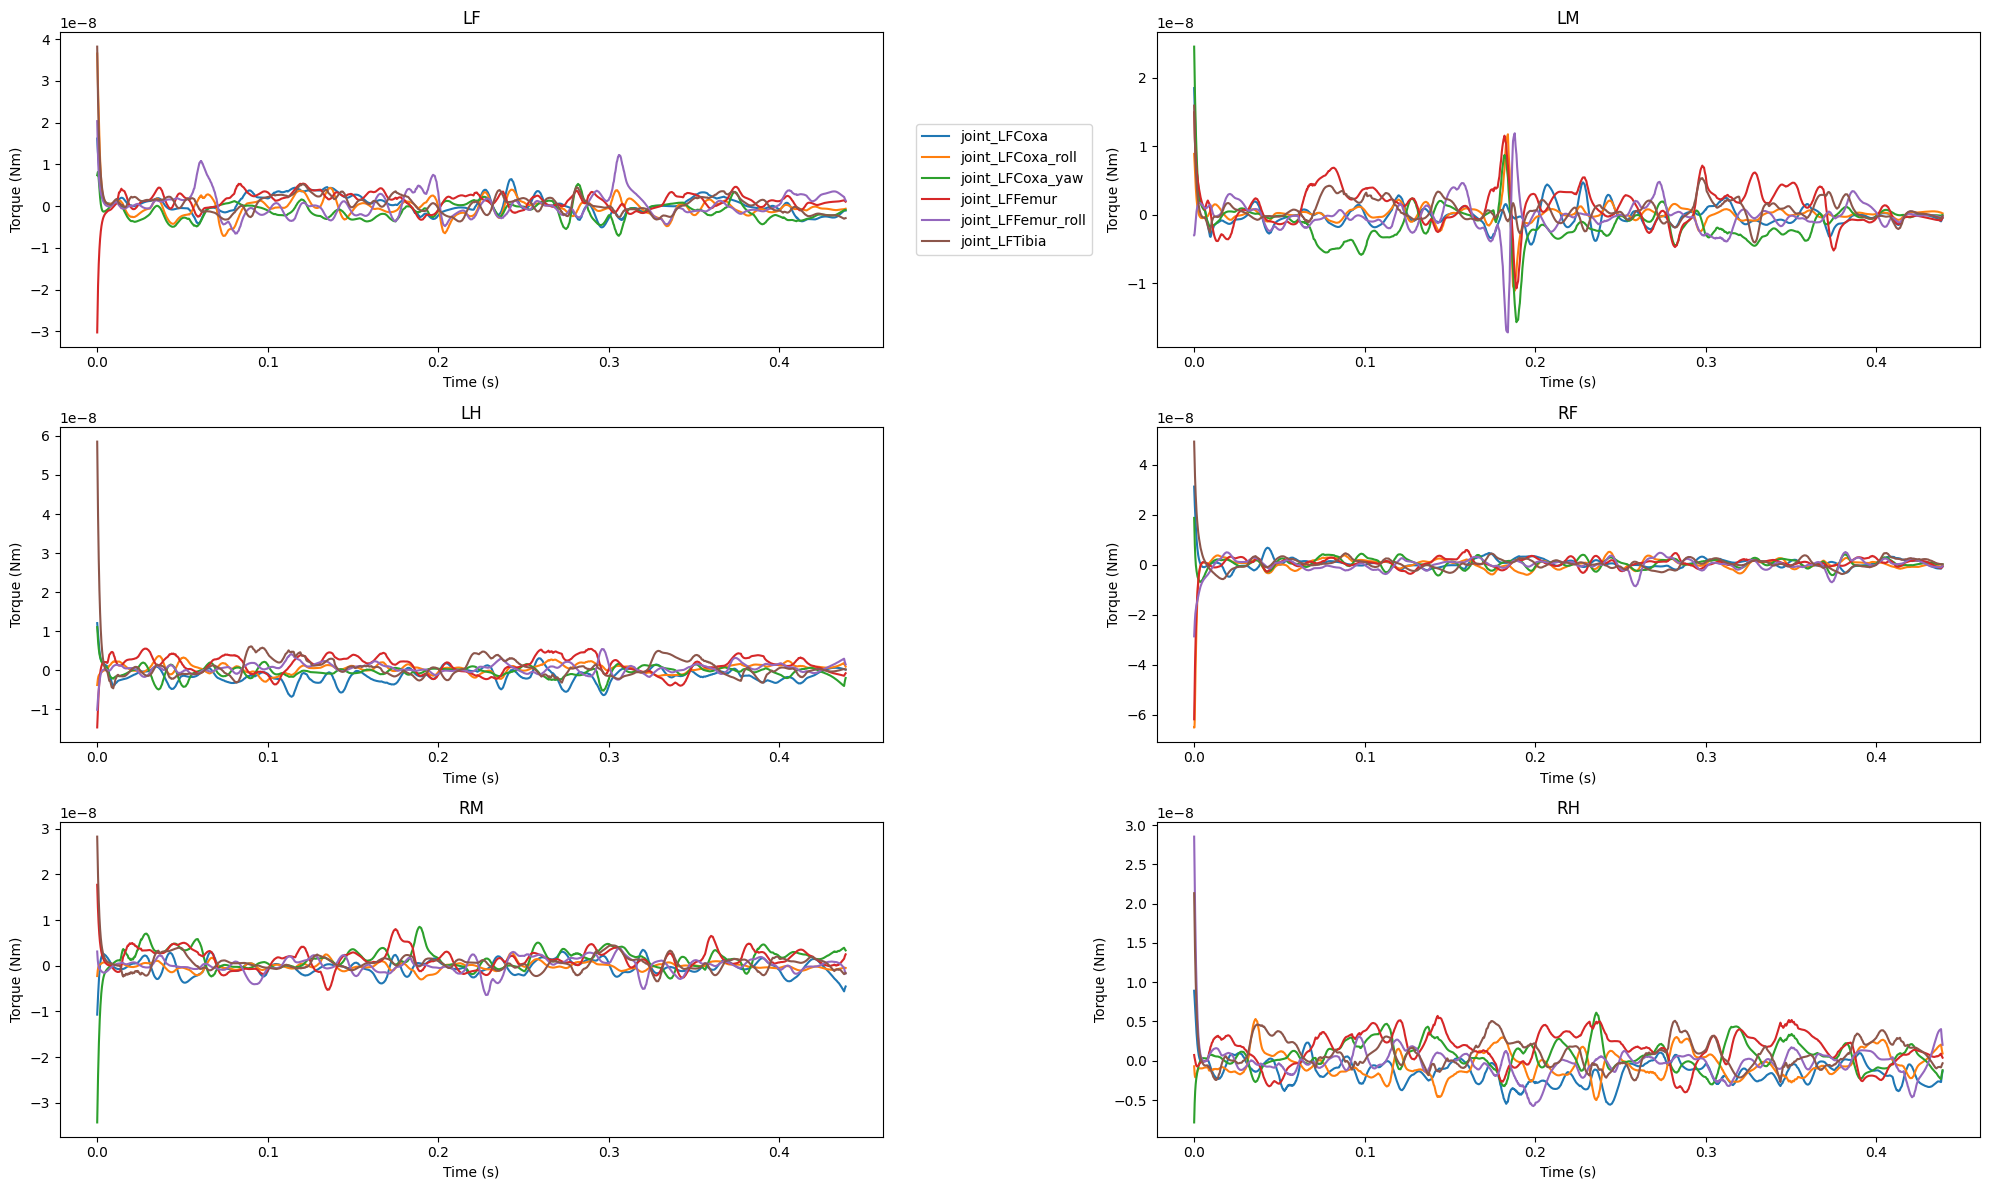

In [23]:
leg_joints_to_id = {leg: [i for i, joint in enumerate(monitored_joints) if leg in joint and not "Tarsus" in joint] for leg in legs}
leg_torques = np.array([[obs["joints"][2, leg_joints_to_id[leg]] for obs in obs_list] for leg in legs])
leg_joints = {leg: [joint for joint in monitored_joints if leg in joint and not "Tarsus" in joint] for leg in legs}

time = np.arange(len(leg_torques[0])) * timestep

fig, axs = plt.subplots(
    3, 2, figsize=(20, 12), tight_layout=True
)

for i, leg in enumerate(legs):
    ax = axs.flatten()[i]
    for j, joint in enumerate(leg_joints[leg]):

        ax.plot(output_t, leg_torques[i, :, j], label=joint)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Torque (Nm)")
    ax.set_title(leg)
    if leg == "LF":
        ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)


### Torque in passive joints (Tarsal joints)

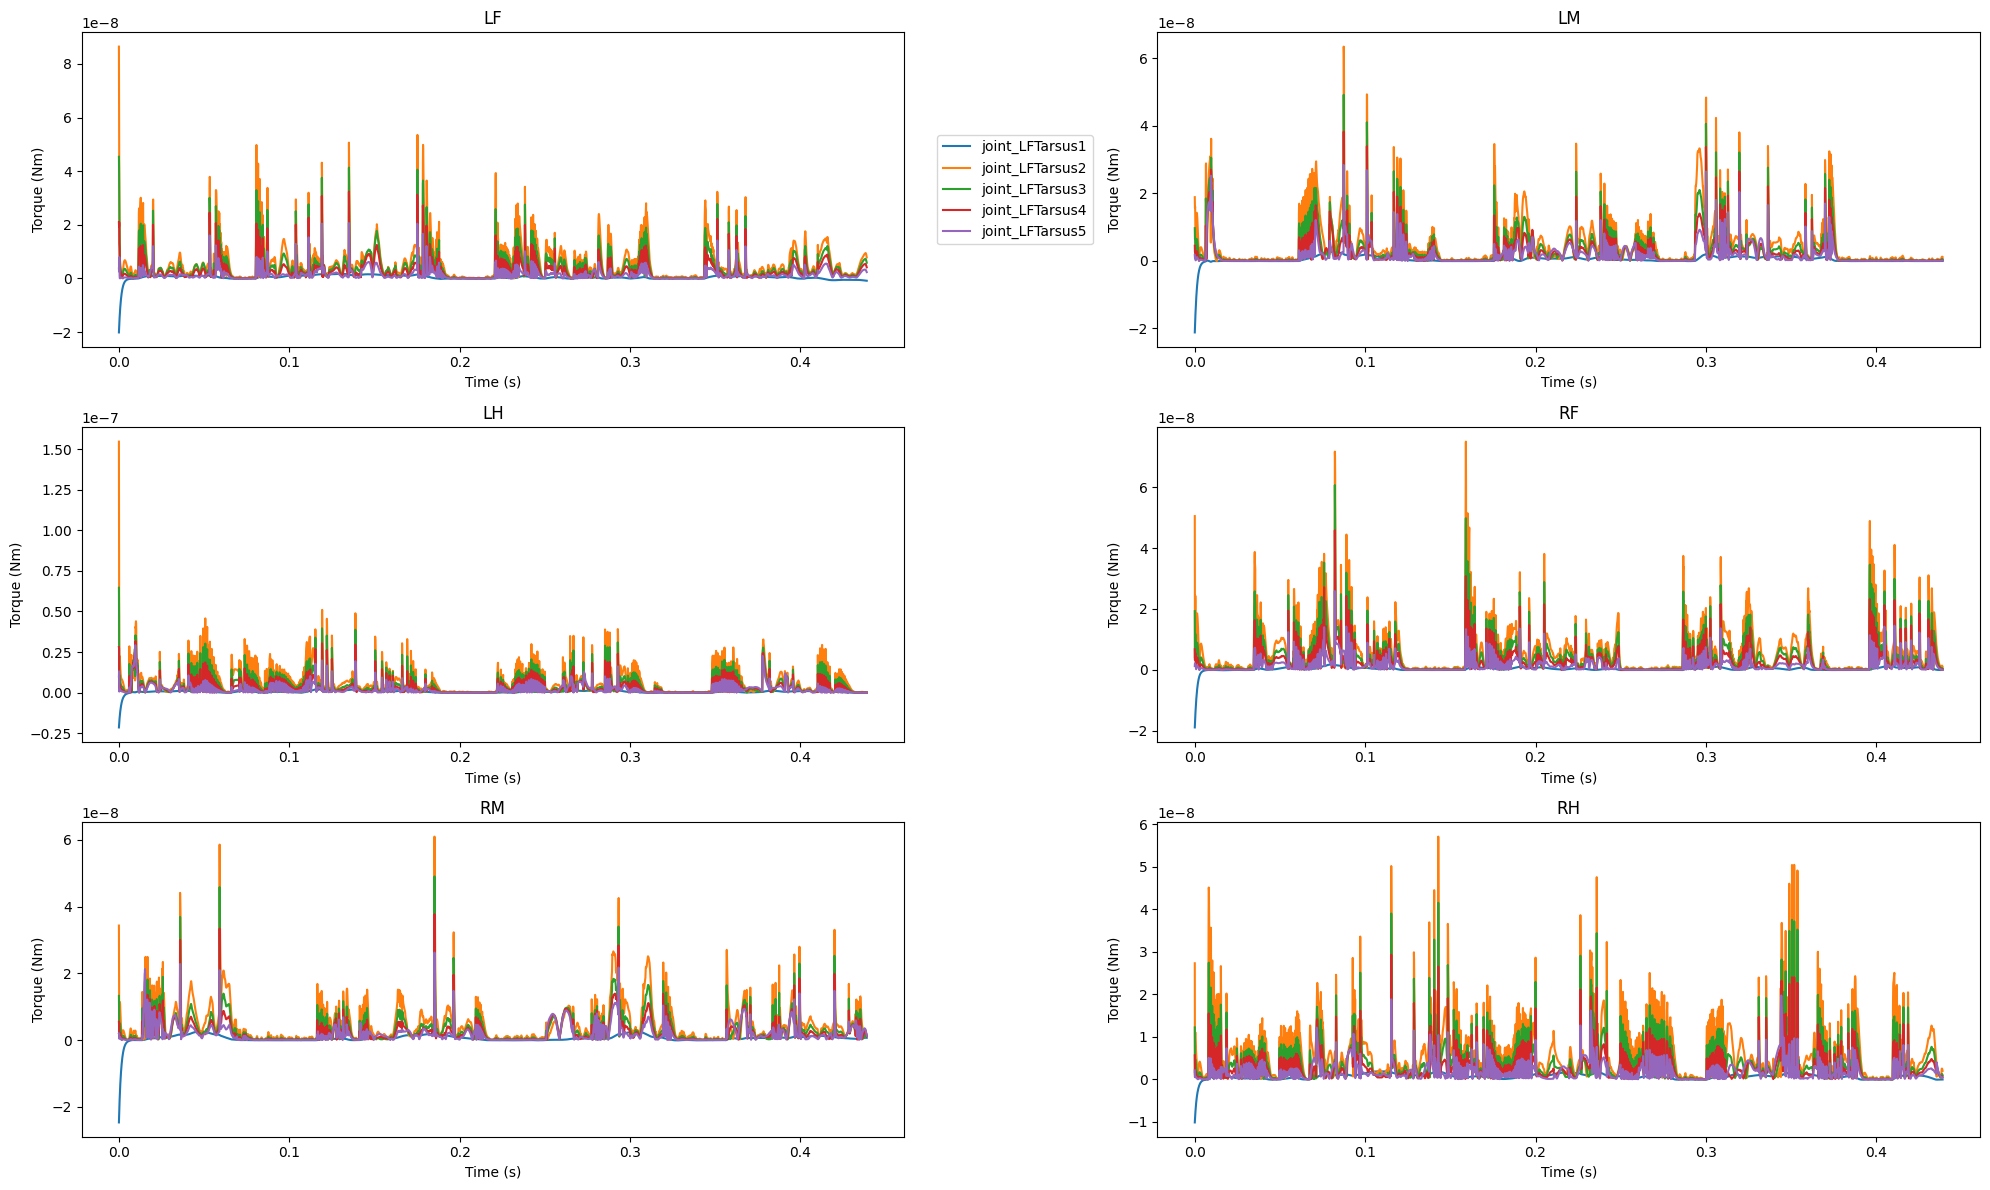

In [24]:
leg_joints_to_id = {leg: [i for i, joint in enumerate(monitored_joints) if leg in joint and "Tarsus" in joint] for leg in legs}
leg_torques = np.array([[obs["joints"][2, leg_joints_to_id[leg]] for obs in obs_list] for leg in legs])
leg_joints = {leg: [joint for joint in monitored_joints if leg in joint and "Tarsus" in joint] for leg in legs}

time = np.arange(len(leg_torques[0])) * timestep

fig, axs = plt.subplots(
    3, 2, figsize=(20, 12), tight_layout=True
)

for i, leg in enumerate(legs):
    ax = axs.flatten()[i]
    for j, joint in enumerate(leg_joints[leg]):

        ax.plot(output_t, leg_torques[i, :, j], label=joint)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Torque (Nm)")
    ax.set_title(leg)
    if leg == "LF":
        ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)


## Tarsus angle

In our model, we do not enforce the position of the tarsal segments. Again due to the small size of the tarsal segments it is hard to measure their relative orientation. With Neuromechfly one can infer the angles between each tarsal segments and fill this gap.

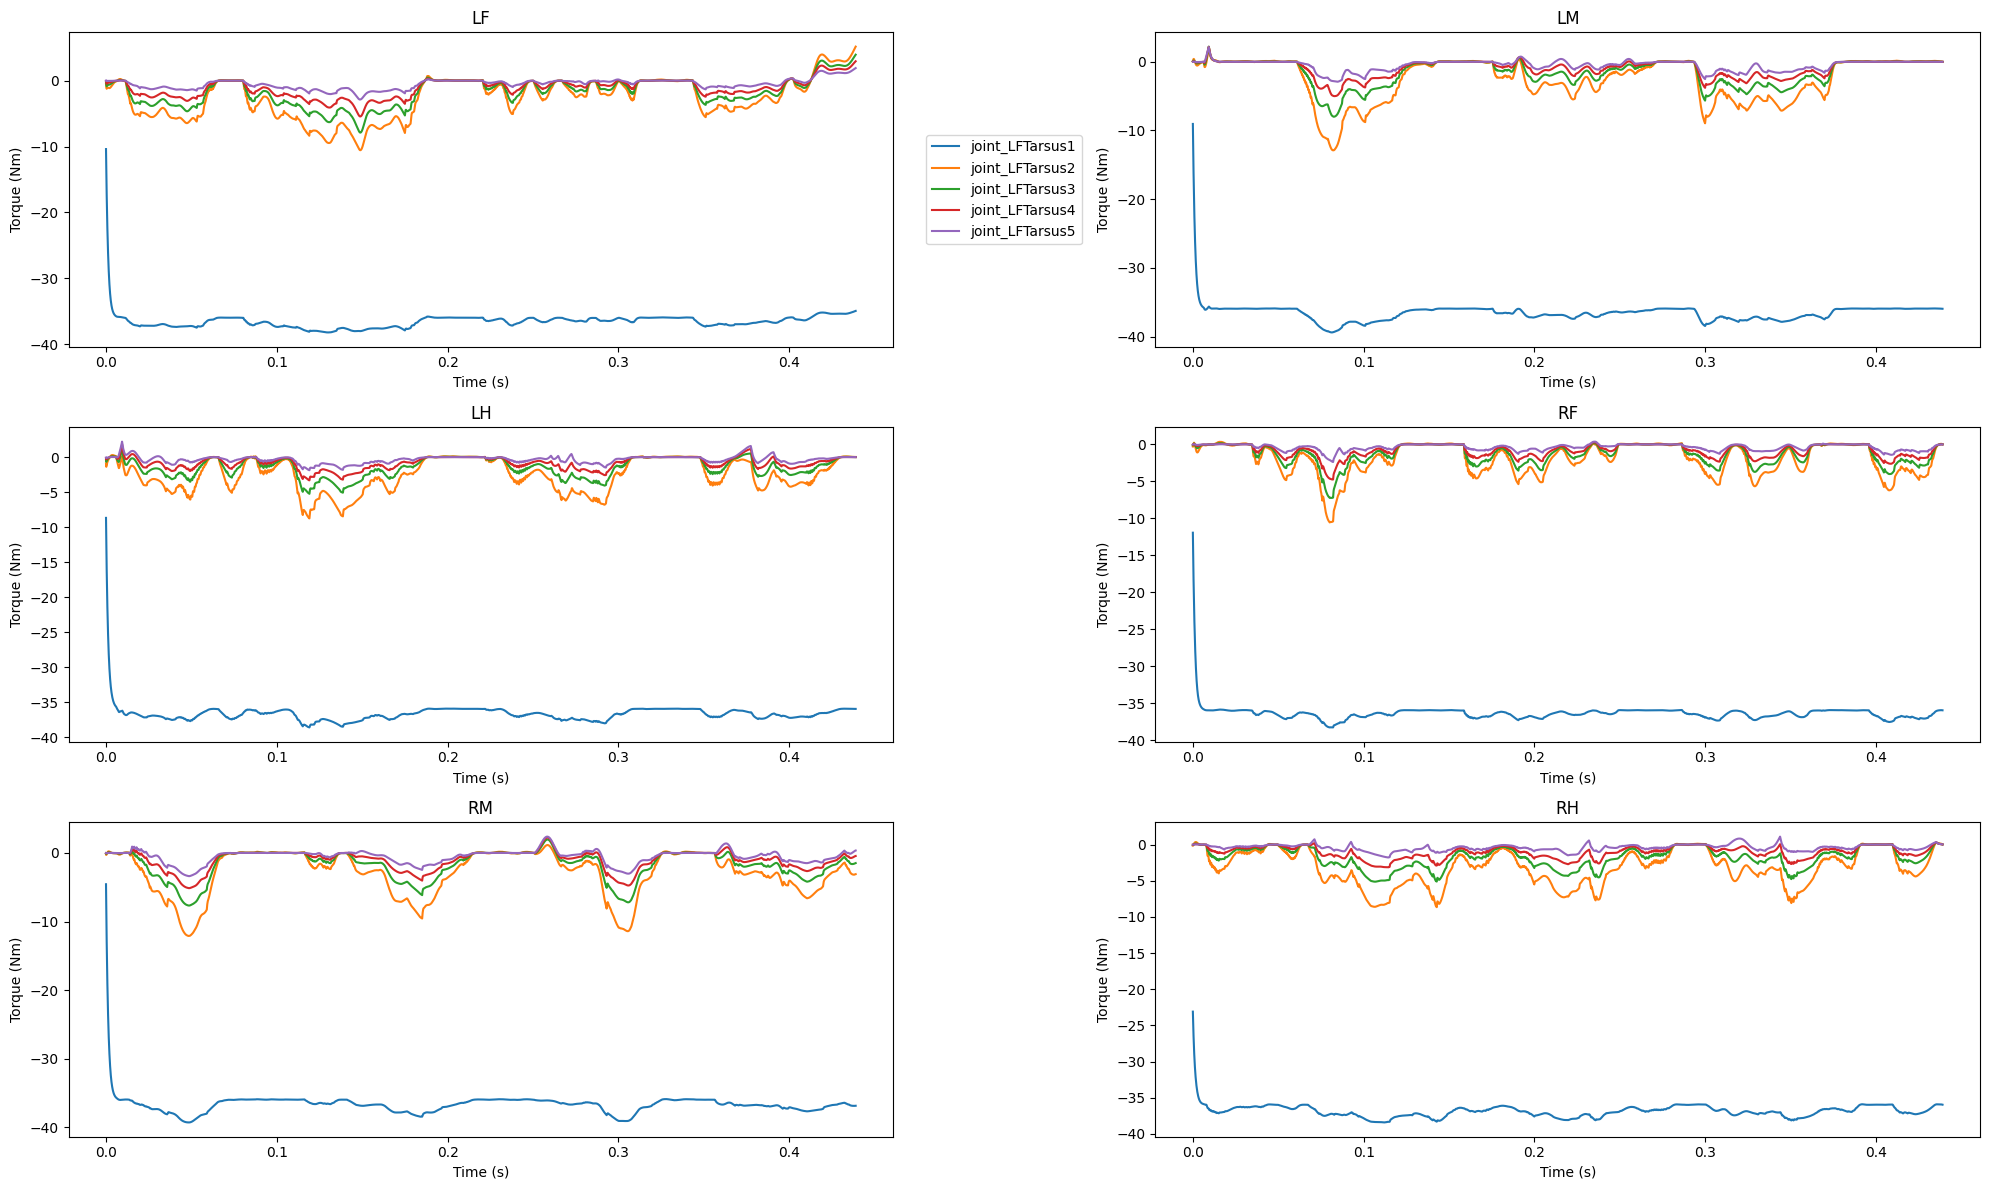

In [25]:
tarsus_joints_to_id = {leg: [i for i, joint in enumerate(monitored_joints) if leg in joint and "Tarsus" in joint] for leg in legs}
tarsus_jointangles = np.array([[obs["joints"][0, tarsus_joints_to_id[leg]] for obs in obs_list] for leg in legs])
tarsus_joints = {leg: [joint for joint in monitored_joints if leg in joint and "Tarsus" in joint] for leg in legs}

time = np.arange(len(leg_torques[0])) * timestep

fig, axs = plt.subplots(
    3, 2, figsize=(20, 12), tight_layout=True
)

for i, leg in enumerate(legs):
    ax = axs.flatten()[i]
    for j, joint in enumerate(tarsus_joints[leg]):
        ax.plot(output_t, np.rad2deg(tarsus_jointangles[i, :, j]), label=joint)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Torque (Nm)")
    ax.set_title(leg)
    if leg == "LF":
        ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)


## Vision

A fly’s compound eye consists of ∼700–750 individual units called ommatidia arranged in a hexagonal pattern (see the left panel of the figure below from the [droso4schools project](https://droso4schools.wordpress.com/l4-enzymes/#5); see also [this article](https://azretina.sites.arizona.edu/node/789) from the Arizona Retina Project). To emulate this, we attached a color camera to each of our model’s compound eyes (top right panel). We then transformed each camera image into 721 bins, representing ommatidia. Based on previous studies, we assume a 270° combined azimuth for the fly’s field of view, with a ∼17° binocular overlap. Visual sensitivity has evolved to highlight ethologically relevant color spectra at different locations in the environment. Here, as an initial step toward enabling this heterogeneity in our model, we implemented yellow- and pale-type ommatidia—sensitive to the green and blue channels of images rendered by the physics simulator—randomly assigned at a 7:3 ratio (as reported in [Rister et al, 2013](https://pubmed.ncbi.nlm.nih.gov/23293281/)). Users can substitute the green and blue channel values with the desired light intensities sensed by yellow- and pale-type ommatidia to achieve more biorealistic chromatic vision.

<img src="https://github.com/NeLy-EPFL/_media/blob/main/flygym/vision_basics/vision.png?raw=true" alt="rule_based" width="800"/>

Neurmechfly v2 is largely oriented toward the modelling of higher order sensory modalities. With Neuromechfly v2 it is now possible to emulate the vision experienced by the fruitfly during behavior. This is again almost impossible to obtain without relying on kinematic relay.

Here is a representation of both the raw output of the cameras as well as the fly's simulated vision.

In [26]:
from flygym.vision.visualize import visualize_visual_input
visualize_visual_input(
    fly.retina,
    output_dir/ "retina_images.mp4",
    vision_list,
    raw_vision_list,
    np.ones(len(raw_vision_list), dtype=bool),
    playback_speed=play_speed)
plt.close("all")

# play the video
mp4 = open(output_dir/ "retina_images.mp4",'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)